# Detecting COVID-19 with Chest XRays using Pytorch

Modified Kaggle Notebook used during guided project from: [![Coursera](https://img.shields.io/badge/Coursera-%230056D2.svg?style=for-the-badge&logo=Coursera&logoColor=white)](https://www.coursera.org/learn/covid-19-detection-x-ray/home)

Hosted Kaggle Notebook: [![Kaggle](https://img.shields.io/badge/Kaggle-035a7d?style=for-the-badge&logo=kaggle&logoColor=white)](https://www.kaggle.com/code/edyvision/detecting-covid-19-with-chest-xrays-pytorch)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

class_names = ['normal', 'viral', 'covid']
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID']
root_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'
write_dir = '/kaggle/working/'

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(write_dir, 'test'))

#     write the folders with class names in test dir
    for c in class_names:
        os.mkdir(os.path.join(write_dir, 'test', c))
        
    for i, src_dir in enumerate(source_dirs):
        shutil.copytree(os.path.join(root_dir, f'{src_dir}/images'), os.path.join(write_dir, class_names[i]))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(write_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(write_dir, c, image)
            target_path = os.path.join(write_dir, 'test', c, image)
            shutil.move(source_path, target_path)
            
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using PyTorch version 2.1.2+cpu


## Creating Custom Dataset

In [10]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [
                x for x in os.listdir(image_dirs[class_name])
                if x.lower().endswith('png')
            ]
            print(f'Found {len(images)} {class_name} examples')
            
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB') # 3 channels for resnet18
        
        return self.transform(image), self.class_names.index(class_name)

## Prepairing Training and Test Sets

In [3]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])

In [4]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])

## Prepare DataLoader

In [12]:
train_dirs = {
    'normal': f'{write_dir}/normal',
    'viral': f'{write_dir}/viral',
    'covid': f'{write_dir}/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10162 normal examples
Found 1315 viral examples
Found 3586 covid examples


In [13]:
test_dirs = {
    'normal': f'{write_dir}/test/normal',
    'viral': f'{write_dir}/test/viral',
    'covid': f'{write_dir}/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [14]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

dl_test = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

print('Num of training batches', len(dl_train))
print('Num of test batches', len(dl_test))

Num of training batches 2511
Num of test batches 15


## Data Visualization

In [41]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    
    for i, image in enumerate(images):
        plt.subplot(1,6, i + 1, xticks=[], yticks=[])
        
        image = image.numpy().transpose((1,2, 0)) # To adhere to matplotlib needs
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
        
    plt.tight_layout()
    plt.show()

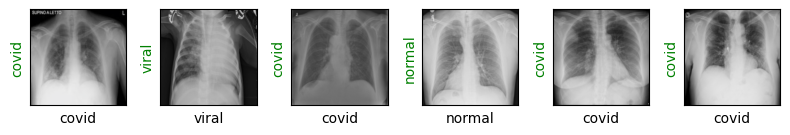

In [42]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

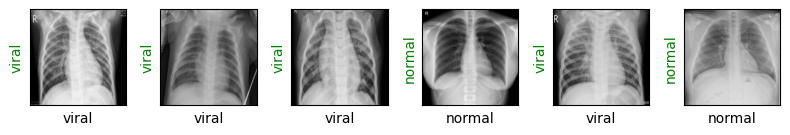

In [43]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

## Creating the Model

In [44]:
resnet = torchvision.models.resnet18(pretrained=True)
print(resnet)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [45]:
resnet.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=3e-5)

In [46]:
def show_preds():
    resnet.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

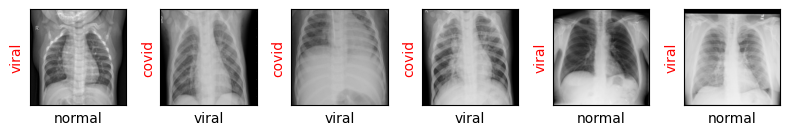

In [47]:
show_preds()

## Training the Model

In [48]:
def train(epochs):
    print('Starting training')
    
    for e in range(0, epochs):
        print('='*30)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*30)
        
        train_loss = 0.
        val_loss = 0.
        
        resnet.train() # set model to training phase
        
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                
                accuracy = 0
                
                resnet.eval() # set the model to evaluation phase
                
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())
                    
                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
                
                show_preds()
                
                resnet.train()
                
                if accuracy >= 0.95:
                    print('Performance condition met')
                    
                    return
                
        train_loss /= (train_step + 1)
        
        print(f'Training Loss: {train_loss:.4f}')
        
    print('Training Completed')
        

Starting training
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.2273, Accuracy: 0.2111


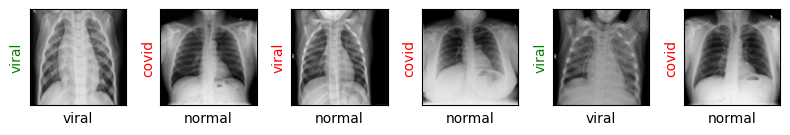

Evaluating at step 20
Validation Loss: 0.9658, Accuracy: 0.5778


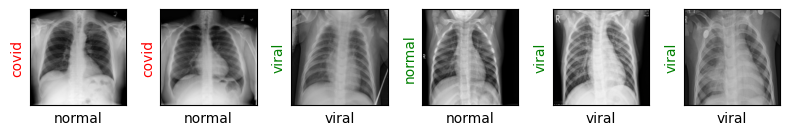

Evaluating at step 40
Validation Loss: 0.6131, Accuracy: 0.7556


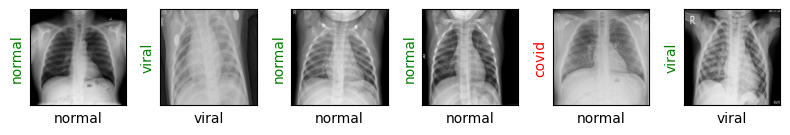

Evaluating at step 60
Validation Loss: 0.3271, Accuracy: 0.9111


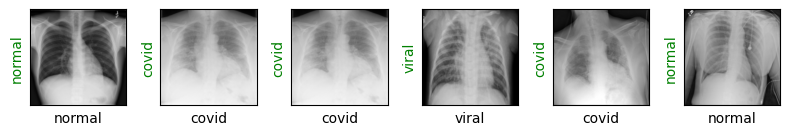

Evaluating at step 80
Validation Loss: 0.2521, Accuracy: 0.9111


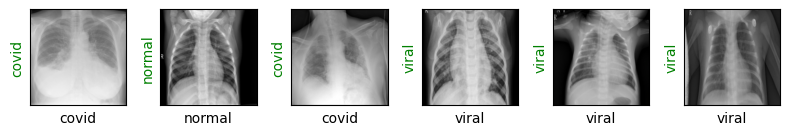

Evaluating at step 100
Validation Loss: 0.2665, Accuracy: 0.9000


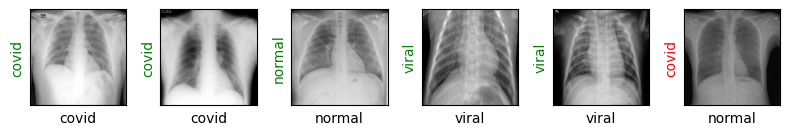

Evaluating at step 120
Validation Loss: 0.2321, Accuracy: 0.9222


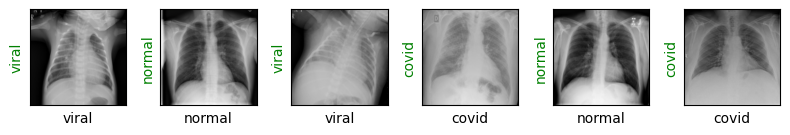

Evaluating at step 140
Validation Loss: 0.2773, Accuracy: 0.8778


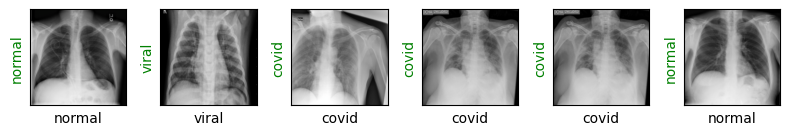

Evaluating at step 160
Validation Loss: 0.2960, Accuracy: 0.9000


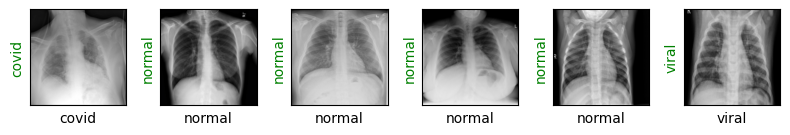

Evaluating at step 180
Validation Loss: 0.1929, Accuracy: 0.9556


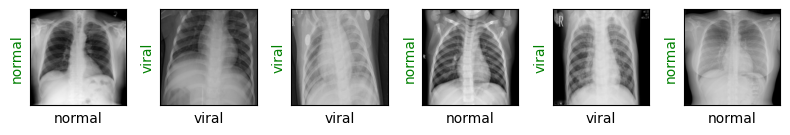

Performance condition met
CPU times: user 6min 23s, sys: 9.29 s, total: 6min 33s
Wall time: 3min 17s


In [49]:
%%time

train(epochs=1)

## Final results

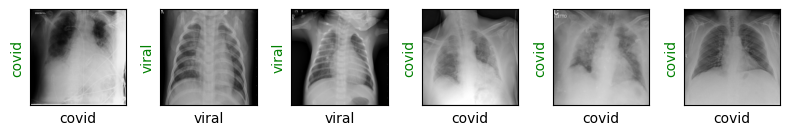

In [50]:
show_preds()